Loading abstract graph from: E:\Network Science Project\RealData\3_abstract_community_network.gexf


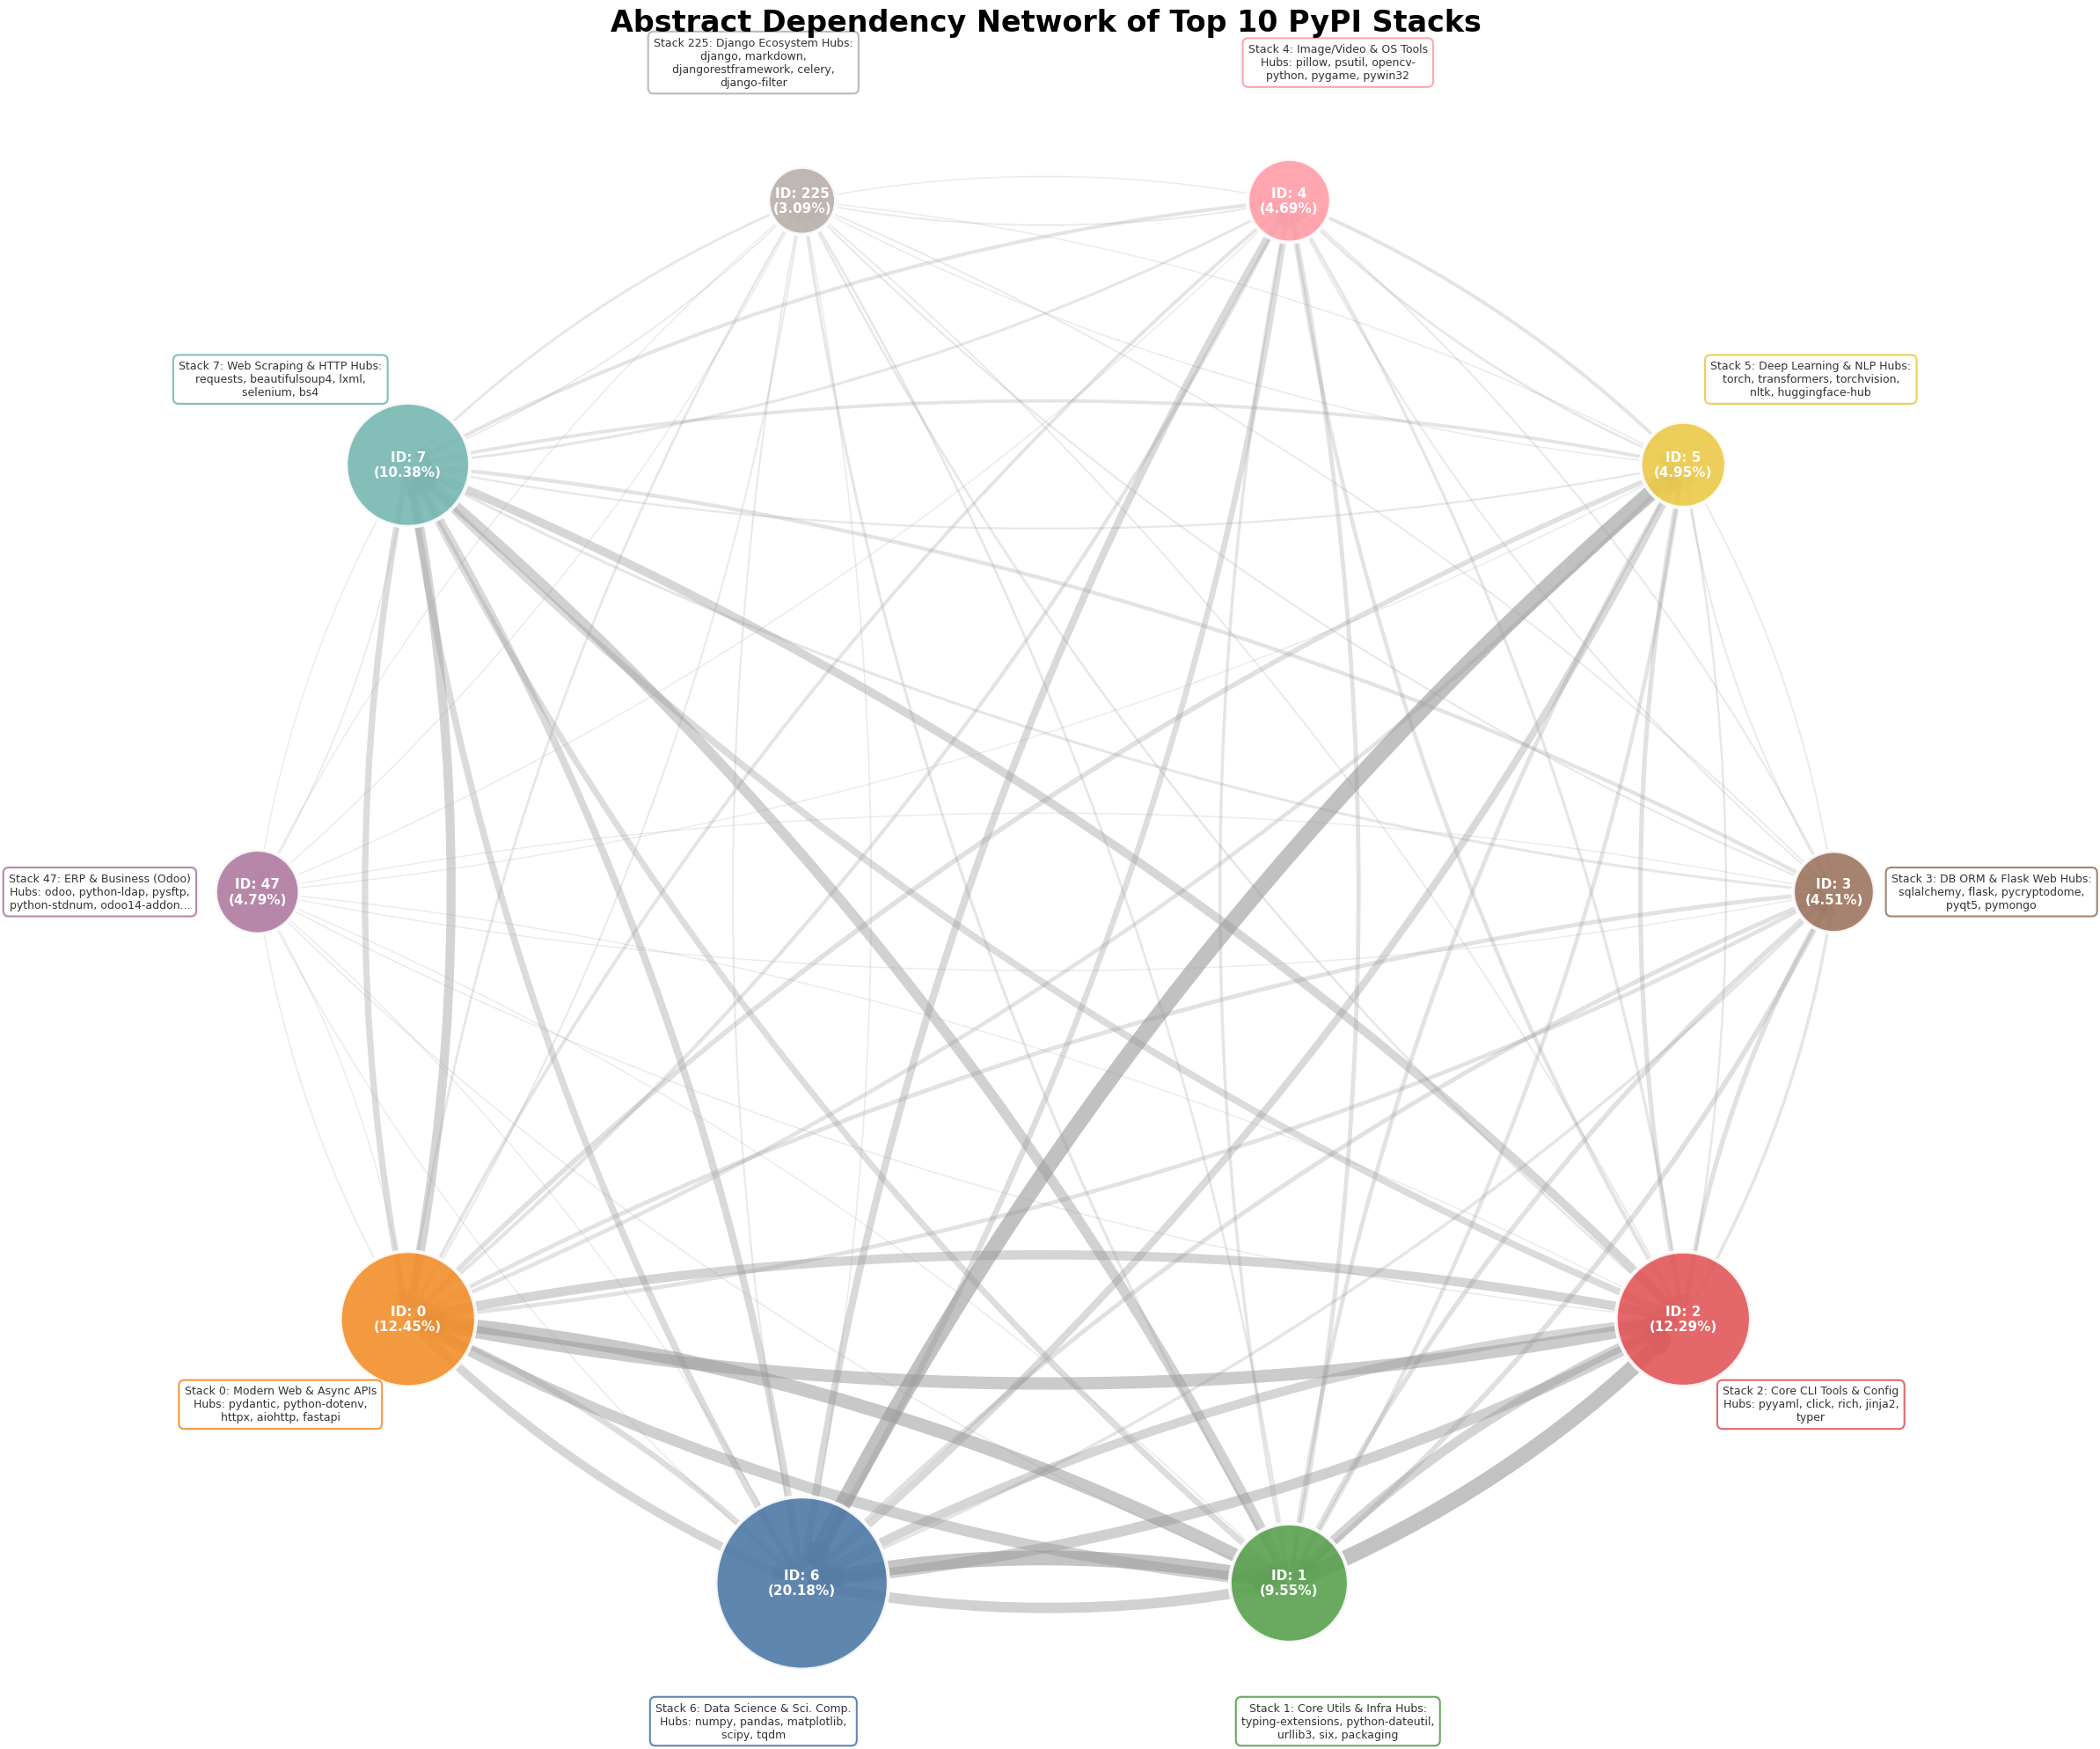

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import textwrap

# ================= 配置 (与上一轮保持一致) =================
DATA_DIR = r"E:\Network Science Project\RealData"
GEXF_FILE = "3_abstract_community_network.gexf"
TOP_K = 10 

# 你的 Stack 详细信息 (保持不变)
STACK_DETAILS = {
    '6': {
        'title': 'Data Science & Sci. Comp.', 
        'share': '20.18%', 
        'hubs': ['numpy', 'pandas', 'matplotlib', 'scipy', 'tqdm']
    },
    '0': {
        'title': 'Modern Web & Async APIs', 
        'share': '12.45%', 
        'hubs': ['pydantic', 'python-dotenv', 'httpx', 'aiohttp', 'fastapi']
    },
    '2': {
        'title': 'Core CLI Tools & Config', 
        'share': '12.29%', 
        'hubs': ['pyyaml', 'click', 'rich', 'jinja2', 'typer']
    },
    '7': {
        'title': 'Web Scraping & HTTP', 
        'share': '10.38%', 
        'hubs': ['requests', 'beautifulsoup4', 'lxml', 'selenium', 'bs4']
    },
    '1': {
        'title': 'Core Utils & Infra', 
        'share': '9.55%', 
        'hubs': ['typing-extensions', 'python-dateutil', 'urllib3', 'six', 'packaging']
    },
    '5': {
        'title': 'Deep Learning & NLP', 
        'share': '4.95%', 
        'hubs': ['torch', 'transformers', 'torchvision', 'nltk', 'huggingface-hub']
    },
    '47': {
        'title': 'ERP & Business (Odoo)', 
        'share': '4.79%', 
        'hubs': ['odoo', 'python-ldap', 'pysftp', 'python-stdnum', 'odoo14-addon...']
    },
    '4': {
        'title': 'Image/Video & OS Tools', 
        'share': '4.69%', 
        'hubs': ['pillow', 'psutil', 'opencv-python', 'pygame', 'pywin32']
    },
    '3': {
        'title': 'DB ORM & Flask Web', 
        'share': '4.51%', 
        'hubs': ['sqlalchemy', 'flask', 'pycryptodome', 'pyqt5', 'pymongo']
    },
    '225': {
        'title': 'Django Ecosystem', 
        'share': '3.09%', 
        'hubs': ['django', 'markdown', 'djangorestframework', 'celery', 'django-filter']
    }
}

STACK_COLORS = {
    '6': '#4E79A7', '0': '#F28E2B', '2': '#E15759', '7': '#76B7B2', '1': '#59A14F',
    '5': '#EDC948', '47': '#B07AA1', '4': '#FF9DA7', '3': '#9C755F', '225': '#BAB0AC'
}
# =================================================

def plot_abstract_network_final_circular():
    file_path = os.path.join(DATA_DIR, GEXF_FILE)
    print(f"Loading abstract graph from: {file_path}")
    
    G = nx.read_gexf(file_path)
    
    # 1. 筛选 Top 10
    node_sizes = {str(n): float(d.get('size', 0)) for n, d in G.nodes(data=True)}
    top_nodes = sorted(node_sizes, key=node_sizes.get, reverse=True)[:TOP_K]
    subG = G.subgraph(top_nodes).copy()
    
    # 调整画布大小
    plt.figure(figsize=(24, 20), facecolor='white') 
    
    # 2. 关键修改：使用 Circular Layout 强制圆形均匀分布
    pos = nx.circular_layout(subG) 
    
    # 3. 数据准备 (保持不变)
    raw_sizes = [node_sizes[str(n)] for n in subG.nodes()]
    max_s = max(raw_sizes)
    draw_sizes = [(s / max_s) * 20000 for s in raw_sizes] 
    colors = [STACK_COLORS.get(str(n), '#999999') for n in subG.nodes()]
    
    # 4. 绘制边 (保持不变)
    edges_to_draw = []
    widths = []
    edge_colors = []
    all_weights = [float(d.get('weight', 1)) for u, v, d in subG.edges(data=True)]
    max_weight = max(all_weights) if all_weights else 1
    
    for u, v, d in subG.edges(data=True):
        weight = float(d.get('weight', 1))
        if weight > 10: 
            edges_to_draw.append((u, v))
            w_scaled = 1 + (weight / max_weight) * 12 
            widths.append(w_scaled)
            alpha = 0.2 + (weight / max_weight) * 0.4
            edge_colors.append((0.6, 0.6, 0.6, alpha)) 

    # 画边
    # 注意：circular layout 上的节点可能非常靠近，弧线可以帮助区分
    nx.draw_networkx_edges(subG, pos, edgelist=edges_to_draw, width=widths, 
                           edge_color=edge_colors, arrowsize=15, 
                           connectionstyle="arc3,rad=0.1")
    
    # 画节点
    nx.draw_networkx_nodes(subG, pos, node_size=draw_sizes, node_color=colors, 
                           alpha=0.9, edgecolors='white', linewidths=3)
    
    # 5. 绘制标签 (分层标注 + 修正 Bug)
    labels_inside = {} 
    
    for node in subG.nodes():
        nid = str(node)
        x, y = pos[node]
        
        if nid in STACK_DETAILS:
            info = STACK_DETAILS[nid]
            
            # 5.1 节点内部标签 (ID + Share)
            labels_inside[node] = f"ID: {nid}\n({info['share']})"
            
            # 5.2 外部详细信息标签 (Title + Hubs)
            hubs_str = ", ".join(info['hubs'])
            external_text = (
                f"Stack {nid}: {info['title']}\n"
                f"Hubs: {hubs_str}"
            )
            wrapped_external = "\n".join(textwrap.wrap(external_text, width=35))
            
            # 调整外部标签位置：使用极坐标计算偏移量
            # Circular Layout 使得 pos 坐标的 x^2 + y^2 接近常数。
            # 外部标签应沿着从中心 (0,0) 指向该节点的射线方向偏移
            
            # 简单偏移 (适用于圆形)：
            offset_factor = 0.2 # 调整这个值来控制标签离圆圈的远近
            
            plt.text(x * (1 + offset_factor), y * (1 + offset_factor), wrapped_external, 
                     fontsize=9, 
                     color='#333333', 
                     horizontalalignment='center', # 保持居中
                     verticalalignment='center',
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', ec=STACK_COLORS.get(nid), alpha=0.9, linewidth=1.5))

    # 绘制节点内部标签 (修正 Bug: fontweight -> font_weight)
    nx.draw_networkx_labels(subG, pos, labels=labels_inside, 
                            font_size=11, font_color='white', **{'font_weight': 'bold'}) # 修正此处

    plt.title("Abstract Dependency Network of Top 10 PyPI Stacks", fontsize=24, pad=20, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_abstract_network_final_circular()

Loading abstract graph from: E:\Network Science Project\RealData\3_abstract_community_network.gexf


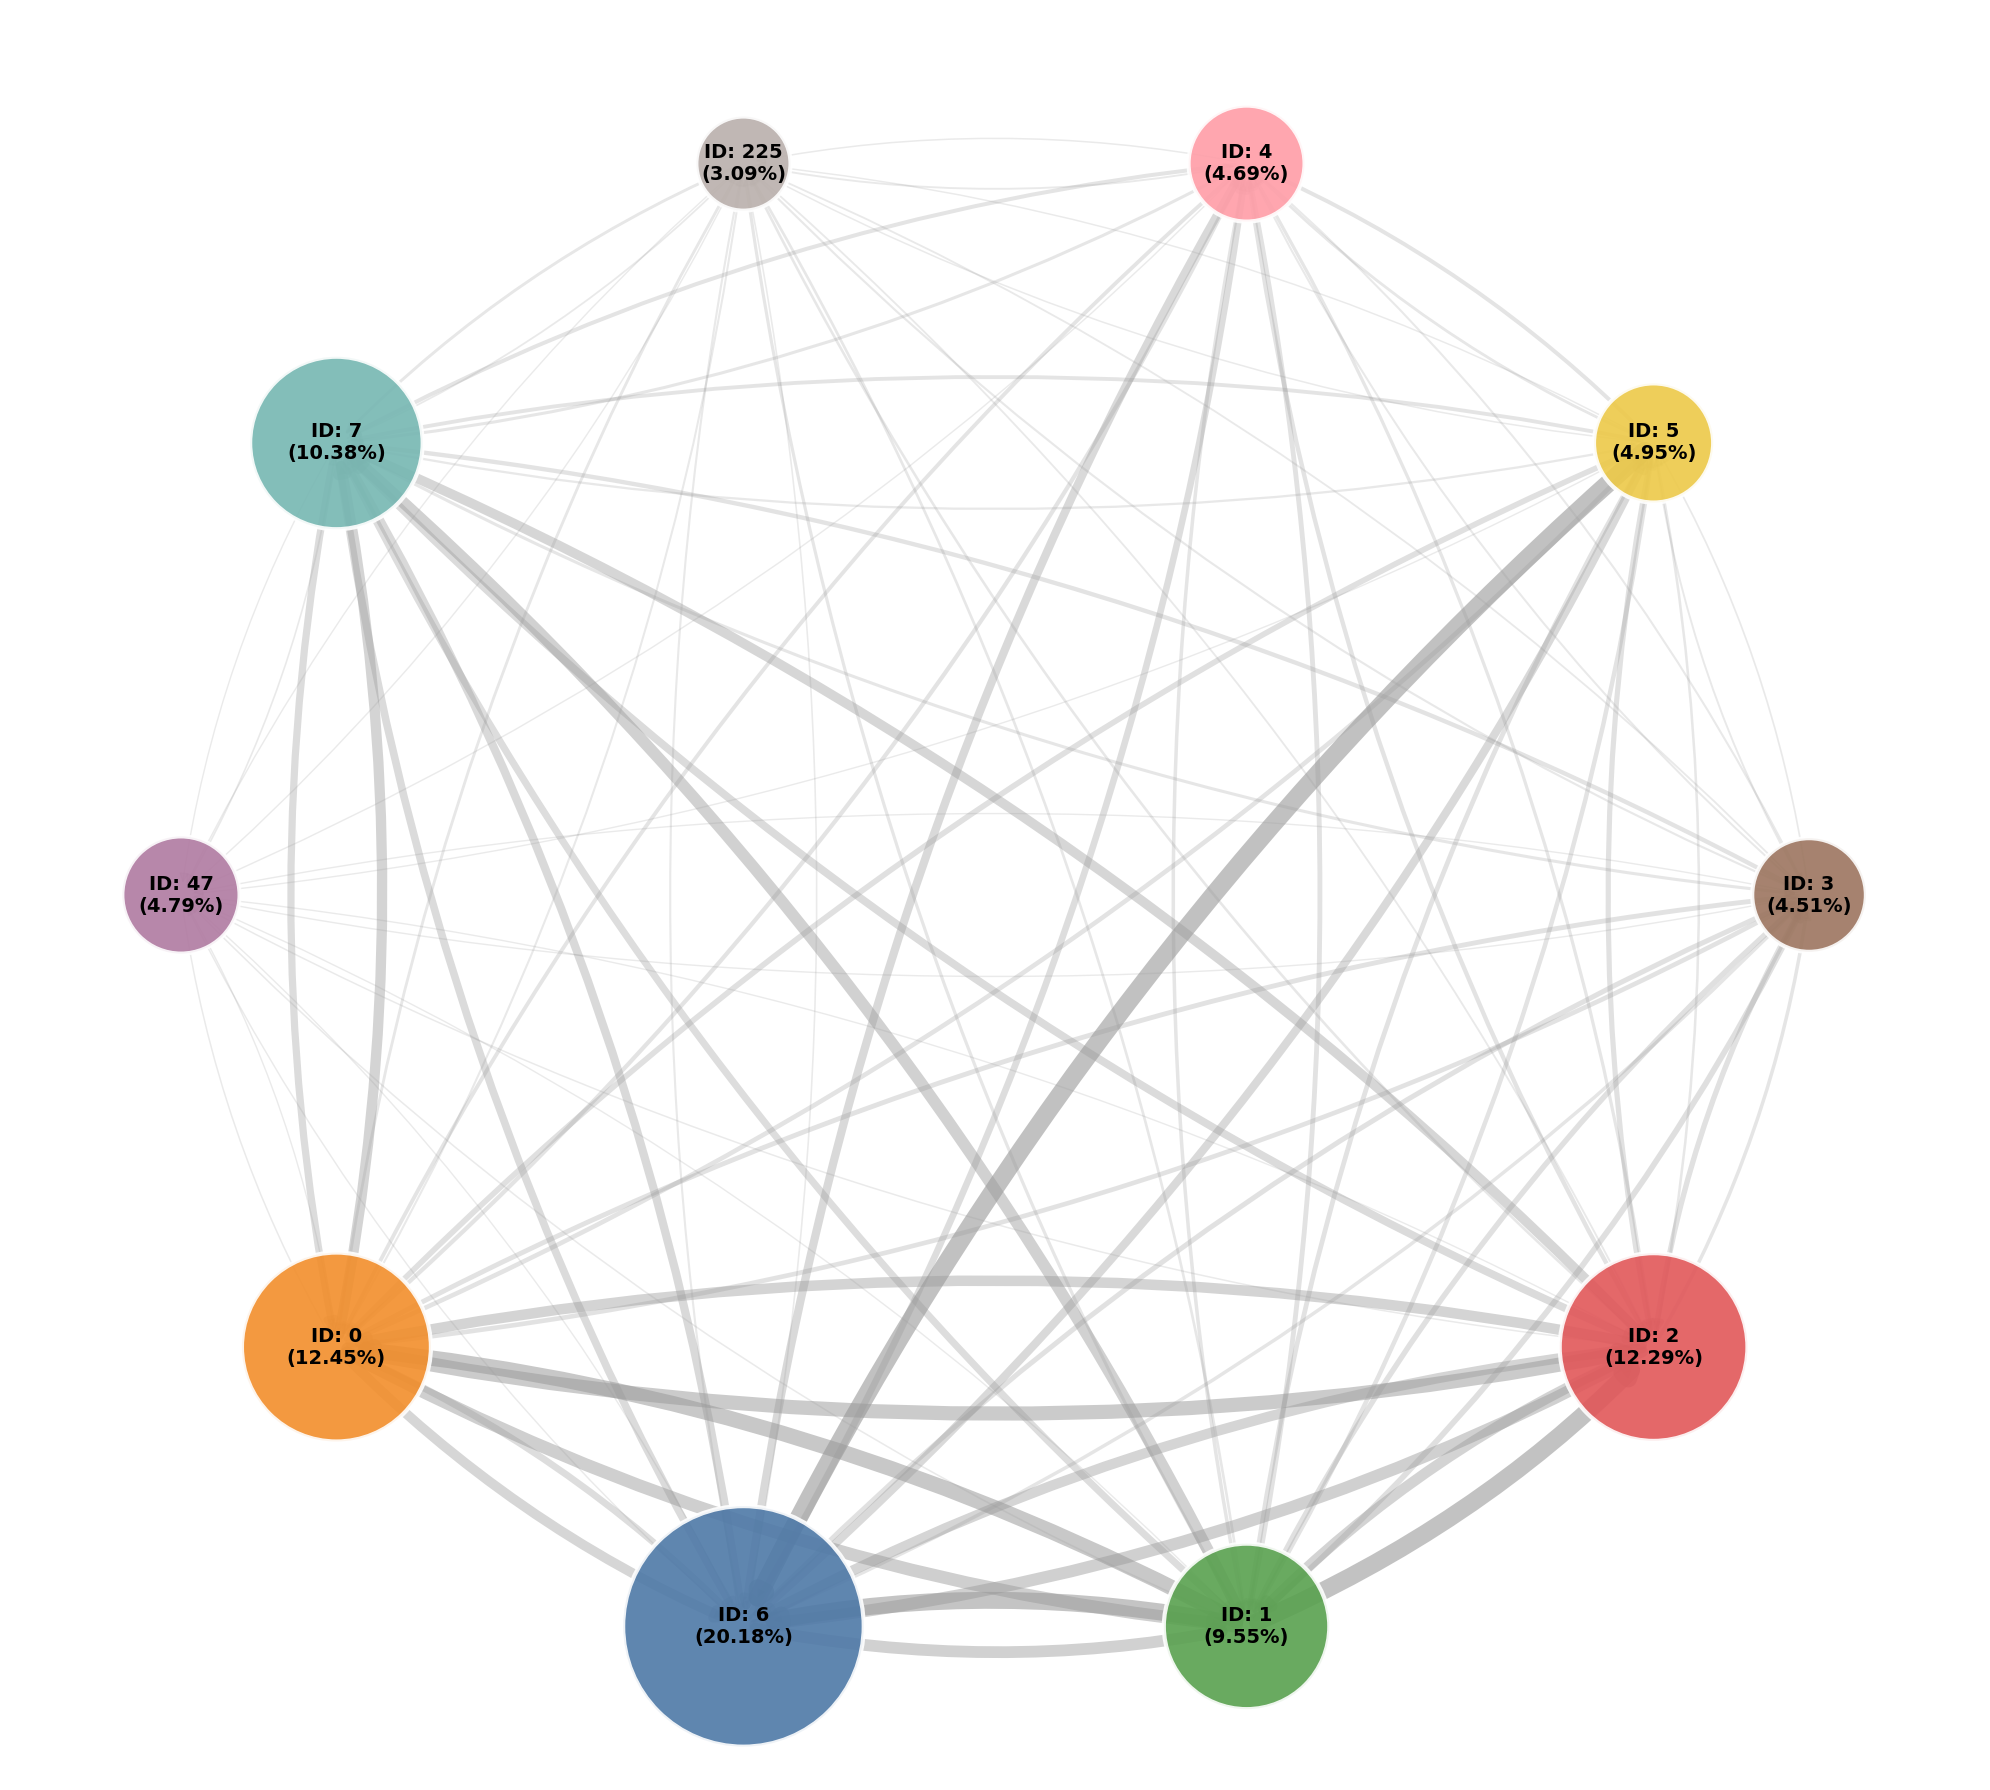

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import textwrap

# ================= 配置 (与上一轮保持一致) =================
DATA_DIR = r"E:\Network Science Project\RealData"
GEXF_FILE = "3_abstract_community_network.gexf"
TOP_K = 10 

# 你的 Stack 详细信息 (保持不变)
STACK_DETAILS = {
    '6': {
        'title': 'Data Science & Sci. Comp.', 
        'share': '20.18%', 
        'hubs': ['numpy', 'pandas', 'matplotlib', 'scipy', 'tqdm']
    },
    '0': {
        'title': 'Modern Web & Async APIs', 
        'share': '12.45%', 
        'hubs': ['pydantic', 'python-dotenv', 'httpx', 'aiohttp', 'fastapi']
    },
    '2': {
        'title': 'Core CLI Tools & Config', 
        'share': '12.29%', 
        'hubs': ['pyyaml', 'click', 'rich', 'jinja2', 'typer']
    },
    '7': {
        'title': 'Web Scraping & HTTP', 
        'share': '10.38%', 
        'hubs': ['requests', 'beautifulsoup4', 'lxml', 'selenium', 'bs4']
    },
    '1': {
        'title': 'Core Utils & Infra', 
        'share': '9.55%', 
        'hubs': ['typing-extensions', 'python-dateutil', 'urllib3', 'six', 'packaging']
    },
    '5': {
        'title': 'Deep Learning & NLP', 
        'share': '4.95%', 
        'hubs': ['torch', 'transformers', 'torchvision', 'nltk', 'huggingface-hub']
    },
    '47': {
        'title': 'ERP & Business (Odoo)', 
        'share': '4.79%', 
        'hubs': ['odoo', 'python-ldap', 'pysftp', 'python-stdnum', 'odoo14-addon...']
    },
    '4': {
        'title': 'Image/Video & OS Tools', 
        'share': '4.69%', 
        'hubs': ['pillow', 'psutil', 'opencv-python', 'pygame', 'pywin32']
    },
    '3': {
        'title': 'DB ORM & Flask Web', 
        'share': '4.51%', 
        'hubs': ['sqlalchemy', 'flask', 'pycryptodome', 'pyqt5', 'pymongo']
    },
    '225': {
        'title': 'Django Ecosystem', 
        'share': '3.09%', 
        'hubs': ['django', 'markdown', 'djangorestframework', 'celery', 'django-filter']
    }
}

STACK_COLORS = {
    '6': '#4E79A7', '0': '#F28E2B', '2': '#E15759', '7': '#76B7B2', '1': '#59A14F',
    '5': '#EDC948', '47': '#B07AA1', '4': '#FF9DA7', '3': '#9C755F', '225': '#BAB0AC'
}
# =================================================

def plot_abstract_network_final_compact():
    file_path = os.path.join(DATA_DIR, GEXF_FILE)
    print(f"Loading abstract graph from: {file_path}")
    
    G = nx.read_gexf(file_path)
    
    # 1. 筛选 Top 10
    node_sizes = {str(n): float(d.get('size', 0)) for n, d in G.nodes(data=True)}
    top_nodes = sorted(node_sizes, key=node_sizes.get, reverse=True)[:TOP_K]
    subG = G.subgraph(top_nodes).copy()
    
    # 画布大小减小 (从 26x22 减到 20x18)，让图更紧凑
    plt.figure(figsize=(20, 18), facecolor='white') 
    
    # 2. 布局：Circular Layout 保持圆形均匀分布
    pos = nx.circular_layout(subG) 
    
    # 3. 数据准备
    raw_sizes = [node_sizes[str(n)] for n in subG.nodes()]
    max_s = max(raw_sizes)
    # 节点大小放大: 从 20000 增大到 30000
    draw_sizes = [(s / max_s) * 30000 for s in raw_sizes] 
    colors = [STACK_COLORS.get(str(n), '#999999') for n in subG.nodes()]
    
    # 4. 绘制边 (保持不变)
    edges_to_draw = []
    widths = []
    edge_colors = []
    all_weights = [float(d.get('weight', 1)) for u, v, d in subG.edges(data=True)]
    max_weight = max(all_weights) if all_weights else 1
    
    for u, v, d in subG.edges(data=True):
        weight = float(d.get('weight', 1))
        if weight > 10: 
            edges_to_draw.append((u, v))
            w_scaled = 1 + (weight / max_weight) * 12 
            widths.append(w_scaled)
            alpha = 0.2 + (weight / max_weight) * 0.4
            edge_colors.append((0.6, 0.6, 0.6, alpha)) 

    # 画边
    nx.draw_networkx_edges(subG, pos, edgelist=edges_to_draw, width=widths, 
                           edge_color=edge_colors, arrowsize=15, 
                           connectionstyle="arc3,rad=0.1")
    
    # 画节点
    nx.draw_networkx_nodes(subG, pos, node_size=draw_sizes, node_color=colors, 
                           alpha=0.9, edgecolors='white', linewidths=3)
    
    # 5. 绘制标签 (分层标注 + 字体放大 + 紧凑化)
    labels_inside = {} 
    
    for node in subG.nodes():
        nid = str(node)
        x, y = pos[node]
        
        if nid in STACK_DETAILS:
            info = STACK_DETAILS[nid]
            
            # 5.1 节点内部标签 (ID + Share)
            labels_inside[node] = f"ID: {nid}\n({info['share']})"
            '''
            # 5.2 外部详细信息标签 (Title + Hubs)
            hubs_str = ", ".join(info['hubs'])
            external_text = (
                f"Stack {nid}: {info['title']}\n"
                f"Hubs: {hubs_str}"
            )
            wrapped_external = "\n".join(textwrap.wrap(external_text, width=35))
            
            # 外部标签定位：
            # 关键修改：将偏移量 (offset_factor) 减小到 0.1，让外部框更贴近节点
            offset_factor = 0.1 
            
            # 外部 Hubs 框字体放大: 从 9 增大到 11 (更清晰)
            plt.text(x * (1 + offset_factor), y * (1 + offset_factor), wrapped_external, 
                     fontsize=11, 
                     color='#333333', 
                     horizontalalignment='center', 
                     verticalalignment='center',
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', ec=STACK_COLORS.get(nid), alpha=0.9, linewidth=1.5))
                     '''
    # 绘制节点内部标签 (字体放大: 从 11 增大到 14)
    nx.draw_networkx_labels(subG, pos, labels=labels_inside, 
                            font_size=14, font_color='black', **{'font_weight': 'bold'}) 

    # plt.title("Abstract Dependency Network of Top 10 PyPI Stacks", fontsize=24, pad=20, fontweight='bold')
    plt.title("", fontsize=24, pad=20, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_abstract_network_final_compact()

Loading abstract graph from: E:\Network Science Project\RealData\3_abstract_community_network.gexf


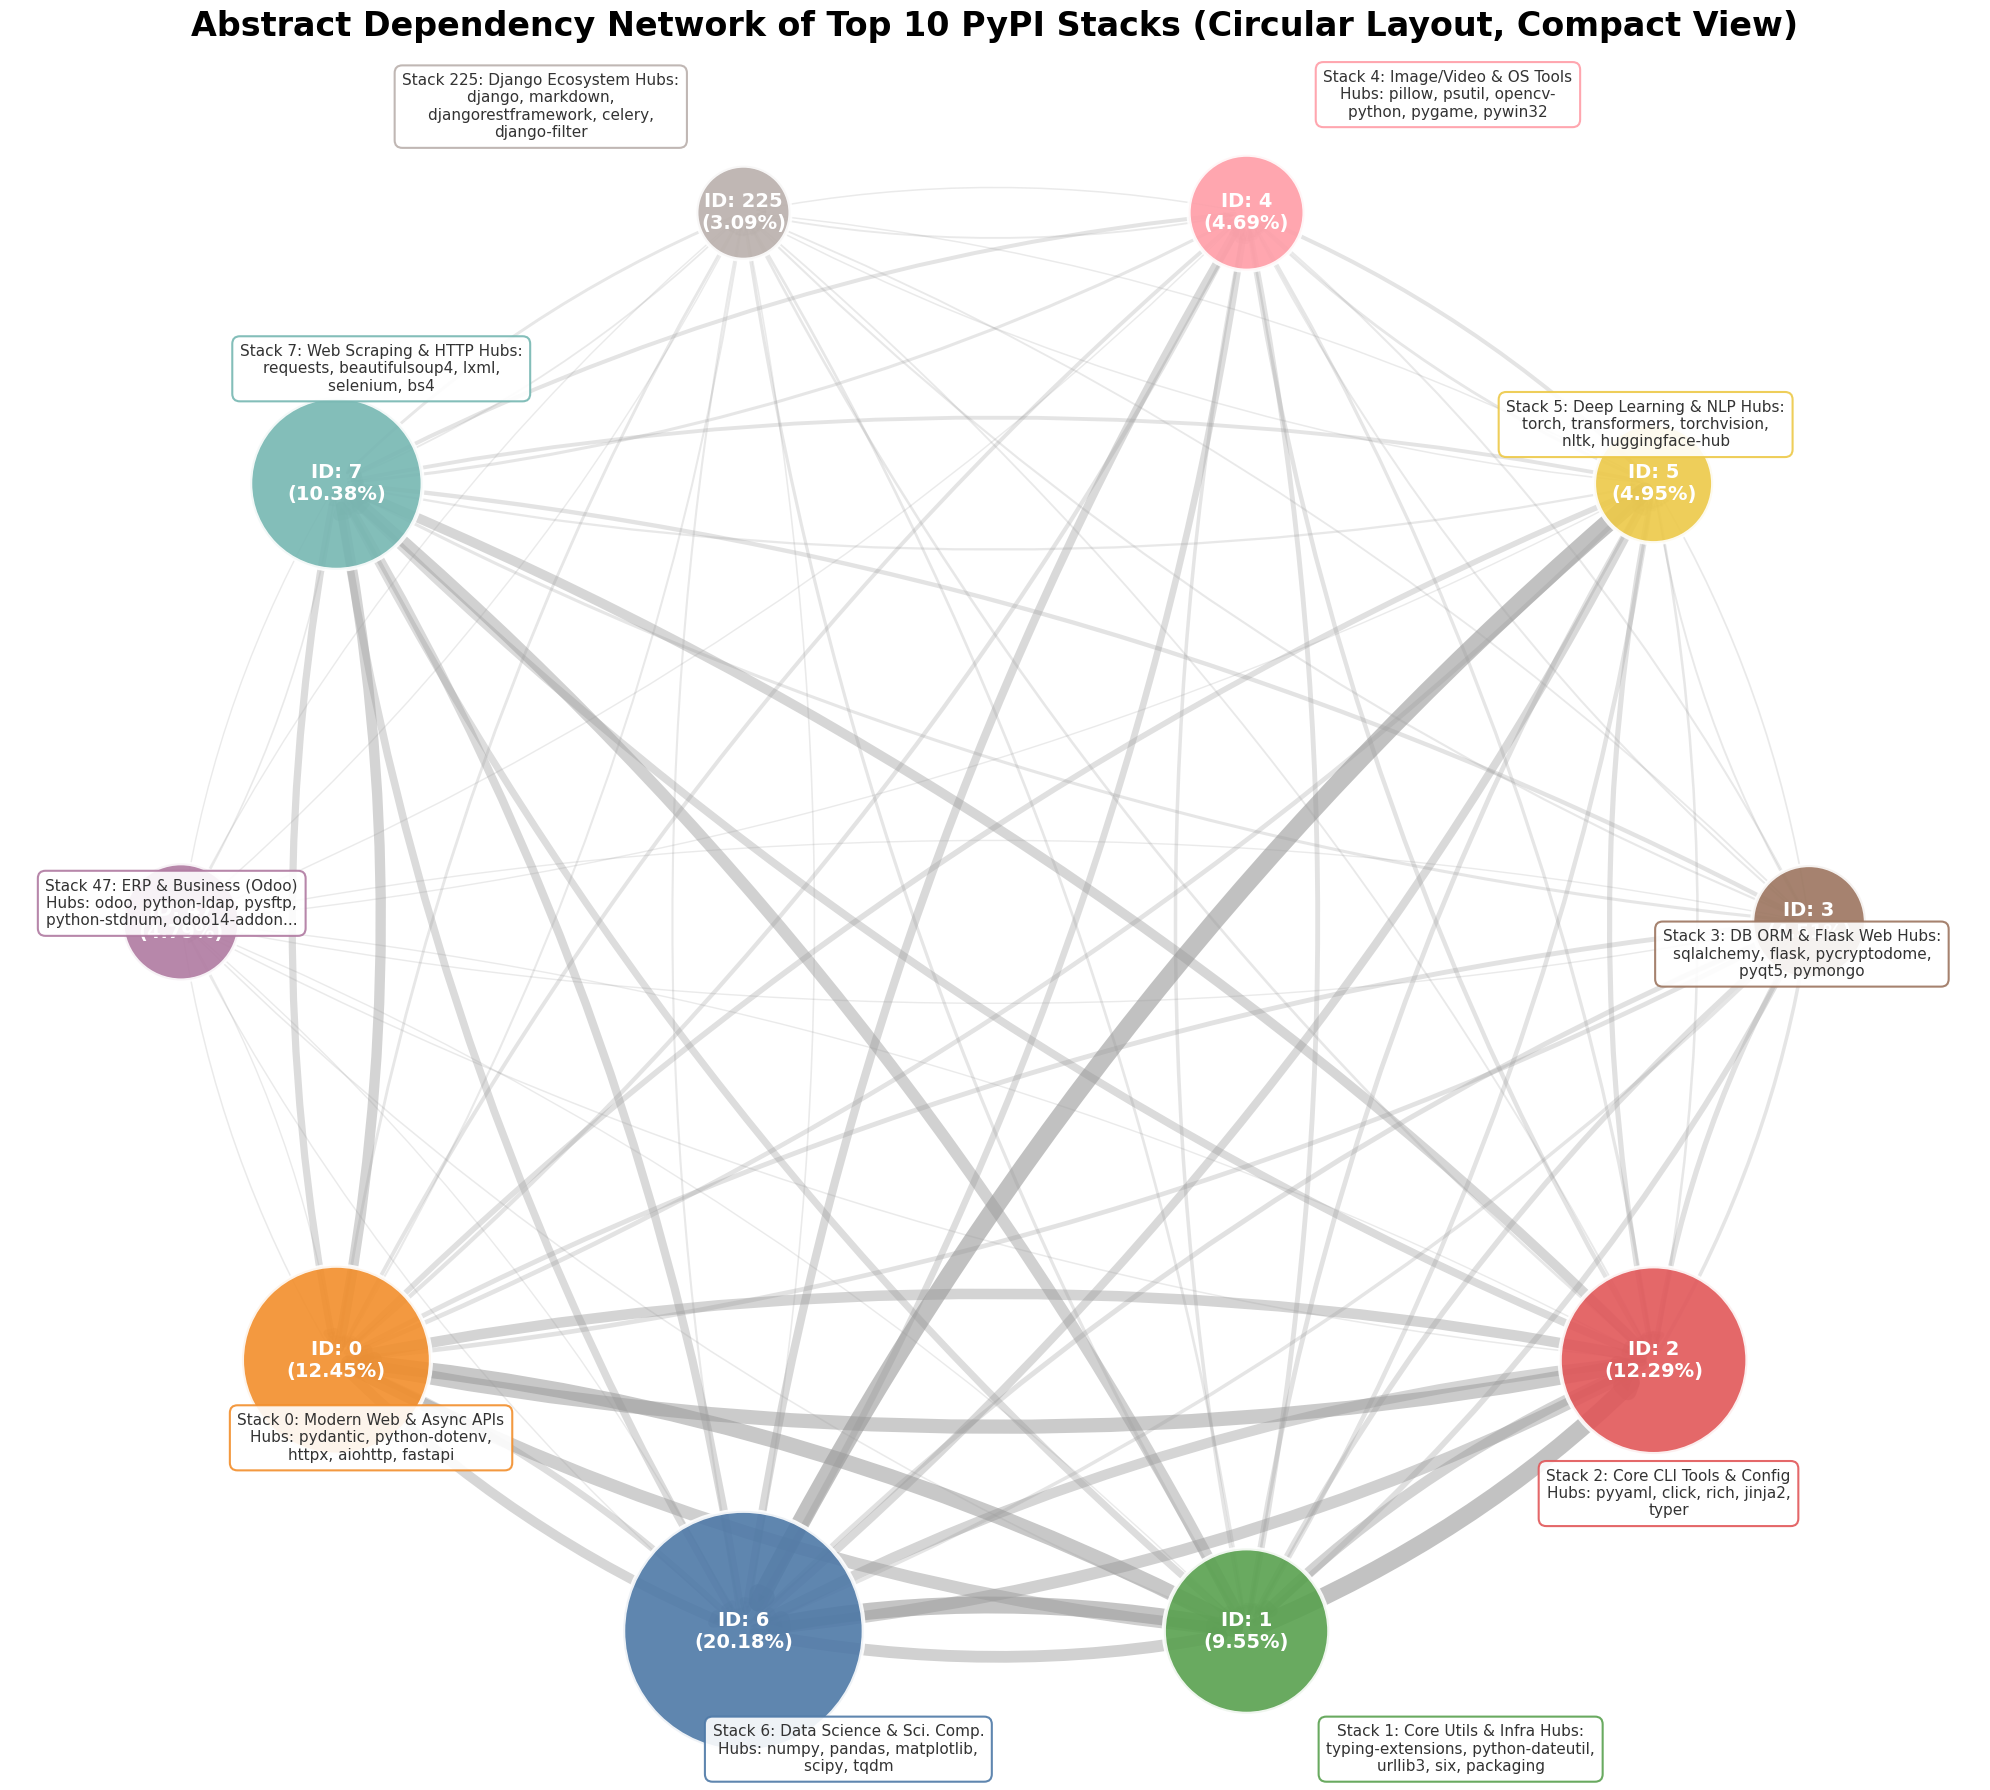

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import textwrap
import numpy as np
from adjustText import adjust_text

# ================= 配置 (与你原始保持一致) =================
DATA_DIR = r"E:\Network Science Project\RealData"
GEXF_FILE = "3_abstract_community_network.gexf"
TOP_K = 10 

STACK_DETAILS = {
    '6': {
        'title': 'Data Science & Sci. Comp.', 
        'share': '20.18%', 
        'hubs': ['numpy', 'pandas', 'matplotlib', 'scipy', 'tqdm']
    },
    '0': {
        'title': 'Modern Web & Async APIs', 
        'share': '12.45%', 
        'hubs': ['pydantic', 'python-dotenv', 'httpx', 'aiohttp', 'fastapi']
    },
    '2': {
        'title': 'Core CLI Tools & Config', 
        'share': '12.29%', 
        'hubs': ['pyyaml', 'click', 'rich', 'jinja2', 'typer']
    },
    '7': {
        'title': 'Web Scraping & HTTP', 
        'share': '10.38%', 
        'hubs': ['requests', 'beautifulsoup4', 'lxml', 'selenium', 'bs4']
    },
    '1': {
        'title': 'Core Utils & Infra', 
        'share': '9.55%', 
        'hubs': ['typing-extensions', 'python-dateutil', 'urllib3', 'six', 'packaging']
    },
    '5': {
        'title': 'Deep Learning & NLP', 
        'share': '4.95%', 
        'hubs': ['torch', 'transformers', 'torchvision', 'nltk', 'huggingface-hub']
    },
    '47': {
        'title': 'ERP & Business (Odoo)', 
        'share': '4.79%', 
        'hubs': ['odoo', 'python-ldap', 'pysftp', 'python-stdnum', 'odoo14-addon...']
    },
    '4': {
        'title': 'Image/Video & OS Tools', 
        'share': '4.69%', 
        'hubs': ['pillow', 'psutil', 'opencv-python', 'pygame', 'pywin32']
    },
    '3': {
        'title': 'DB ORM & Flask Web', 
        'share': '4.51%', 
        'hubs': ['sqlalchemy', 'flask', 'pycryptodome', 'pyqt5', 'pymongo']
    },
    '225': {
        'title': 'Django Ecosystem', 
        'share': '3.09%', 
        'hubs': ['django', 'markdown', 'djangorestframework', 'celery', 'django-filter']
    }
}

STACK_COLORS = {
    '6': '#4E79A7', '0': '#F28E2B', '2': '#E15759', '7': '#76B7B2', '1': '#59A14F',
    '5': '#EDC948', '47': '#B07AA1', '4': '#FF9DA7', '3': '#9C755F', '225': '#BAB0AC'
}
# =================================================

def plot_abstract_network_final_compact():
    file_path = os.path.join(DATA_DIR, GEXF_FILE)
    print(f"Loading abstract graph from: {file_path}")
    
    G = nx.read_gexf(file_path)
    
    # 1. 筛选 Top K（保持不变）
    node_sizes = {str(n): float(d.get('size', 0)) for n, d in G.nodes(data=True)}
    top_nodes = sorted(node_sizes, key=node_sizes.get, reverse=True)[:TOP_K]
    subG = G.subgraph(top_nodes).copy()
    
    # 画布大小保持你原来的 20x18（按你想要的）
    plt.figure(figsize=(20, 18), facecolor='white') 
    
    # 2. 布局：先用 circular layout，然后整体 **略微缩小坐标**（保留原布局但给外圈留空白）
    pos = nx.circular_layout(subG)
    shrink_factor = 0.82   # <1 => 整体向内收，数量可微调（0.75~0.9 区间试验）
    pos = {n: shrink_factor * coords for n, coords in pos.items()}
    
    # 3. 数据准备（保持你原样）
    raw_sizes = [node_sizes[str(n)] for n in subG.nodes()]
    max_s = max(raw_sizes) if raw_sizes else 1
    draw_sizes = [(s / max_s) * 30000 for s in raw_sizes] 
    colors = [STACK_COLORS.get(str(n), '#999999') for n in subG.nodes()]
    
    # 4. 绘制边（**完全保留你的原逻辑**）
    edges_to_draw = []
    widths = []
    edge_colors = []
    all_weights = [float(d.get('weight', 1)) for u, v, d in subG.edges(data=True)]
    max_weight = max(all_weights) if all_weights else 1
    
    for u, v, d in subG.edges(data=True):
        weight = float(d.get('weight', 1))
        if weight > 10: 
            edges_to_draw.append((u, v))
            w_scaled = 1 + (weight / max_weight) * 12 
            widths.append(w_scaled)
            alpha = 0.2 + (weight / max_weight) * 0.4
            edge_colors.append((0.6, 0.6, 0.6, alpha)) 

    # 画边（不改）
    nx.draw_networkx_edges(subG, pos, edgelist=edges_to_draw, width=widths, 
                           edge_color=edge_colors, arrowsize=15, 
                           connectionstyle="arc3,rad=0.1")
    
    # 画节点（不改）
    nx.draw_networkx_nodes(subG, pos, node_size=draw_sizes, node_color=colors, 
                           alpha=0.9, edgecolors='white', linewidths=3)
    
    # 5. 标签：先准备节点内部标签（与原来一致），并画出 **内部标签（保持原方式）**
    labels_inside = {} 
    for node in subG.nodes():
        nid = str(node)
        if nid in STACK_DETAILS:
            info = STACK_DETAILS[nid]
            labels_inside[node] = f"ID: {nid}\n({info['share']})"
    
    # 先画内部标签（使用原方法，保证样式不变）
    # 我们接下来采集这些内部文本对象作为“不可侵入对象”
    ax = plt.gca()
    nx.draw_networkx_labels(subG, pos, labels=labels_inside, 
                            font_size=14, font_color='white', **{'font_weight': 'bold'}) 

    # snapshot 当前轴上的文本对象（这些包含刚画的内部标签）
    inner_texts = list(ax.texts)[:]  # 复制一份，作为 adjust_text 的不可侵入对象

    # 6. 外部说明框（只移动位置、不要改变样式或加线）
    external_texts = []
    for node in subG.nodes():
        nid = str(node)
        x, y = pos[node]
        
        if nid in STACK_DETAILS:
            info = STACK_DETAILS[nid]
            hubs_str = ", ".join(info['hubs'])
            external_text = (
                f"Stack {nid}: {info['title']}\n"
                f"Hubs: {hubs_str}"
            )
            wrapped_external = "\n".join(textwrap.wrap(external_text, width=35))
            
            # 初始放置：沿节点辐射方向稍微偏移（比你原来更靠近节点）
            angle = np.arctan2(y, x)
            offset = 0.18   # 初始偏移半径（适当留白），可在 0.15~0.22 之间微调
            dx = offset * np.cos(angle)
            dy = offset * np.sin(angle)
            
            txt = plt.text(x + dx, y + dy, wrapped_external, 
                           fontsize=11, 
                           color='#333333', 
                           horizontalalignment='center', 
                           verticalalignment='center',
                           bbox=dict(boxstyle='round,pad=0.5', fc='white', ec=STACK_COLORS.get(nid), alpha=0.9, linewidth=1.5))
            external_texts.append(txt)
    
    # 7. 调整外部框位置，**禁止任何额外引导线或箭头**，并把内部标签作为不可侵入对象
    # 仅允许 external_texts 移动（texts），不移动内置对象
    adjust_text(
        external_texts,
        objects=inner_texts,               # 把内部标签作为 "不准碰" 的对象
        only_move={'points': 'y', 'texts': 'xy'},
        expand_text=(1.05, 1.05),          # 文本扩展约束，避免移得太远
        expand_objects=(1.0, 1.0),
        arrowprops=None                    # 明确：不画细线（没有额外的细线）
    )
    
    # 其余保持不变
    plt.title("Abstract Dependency Network of Top 10 PyPI Stacks (Circular Layout, Compact View)", fontsize=24, pad=20, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_abstract_network_final_compact()


--- Visualizing Core of Stack 6 ---


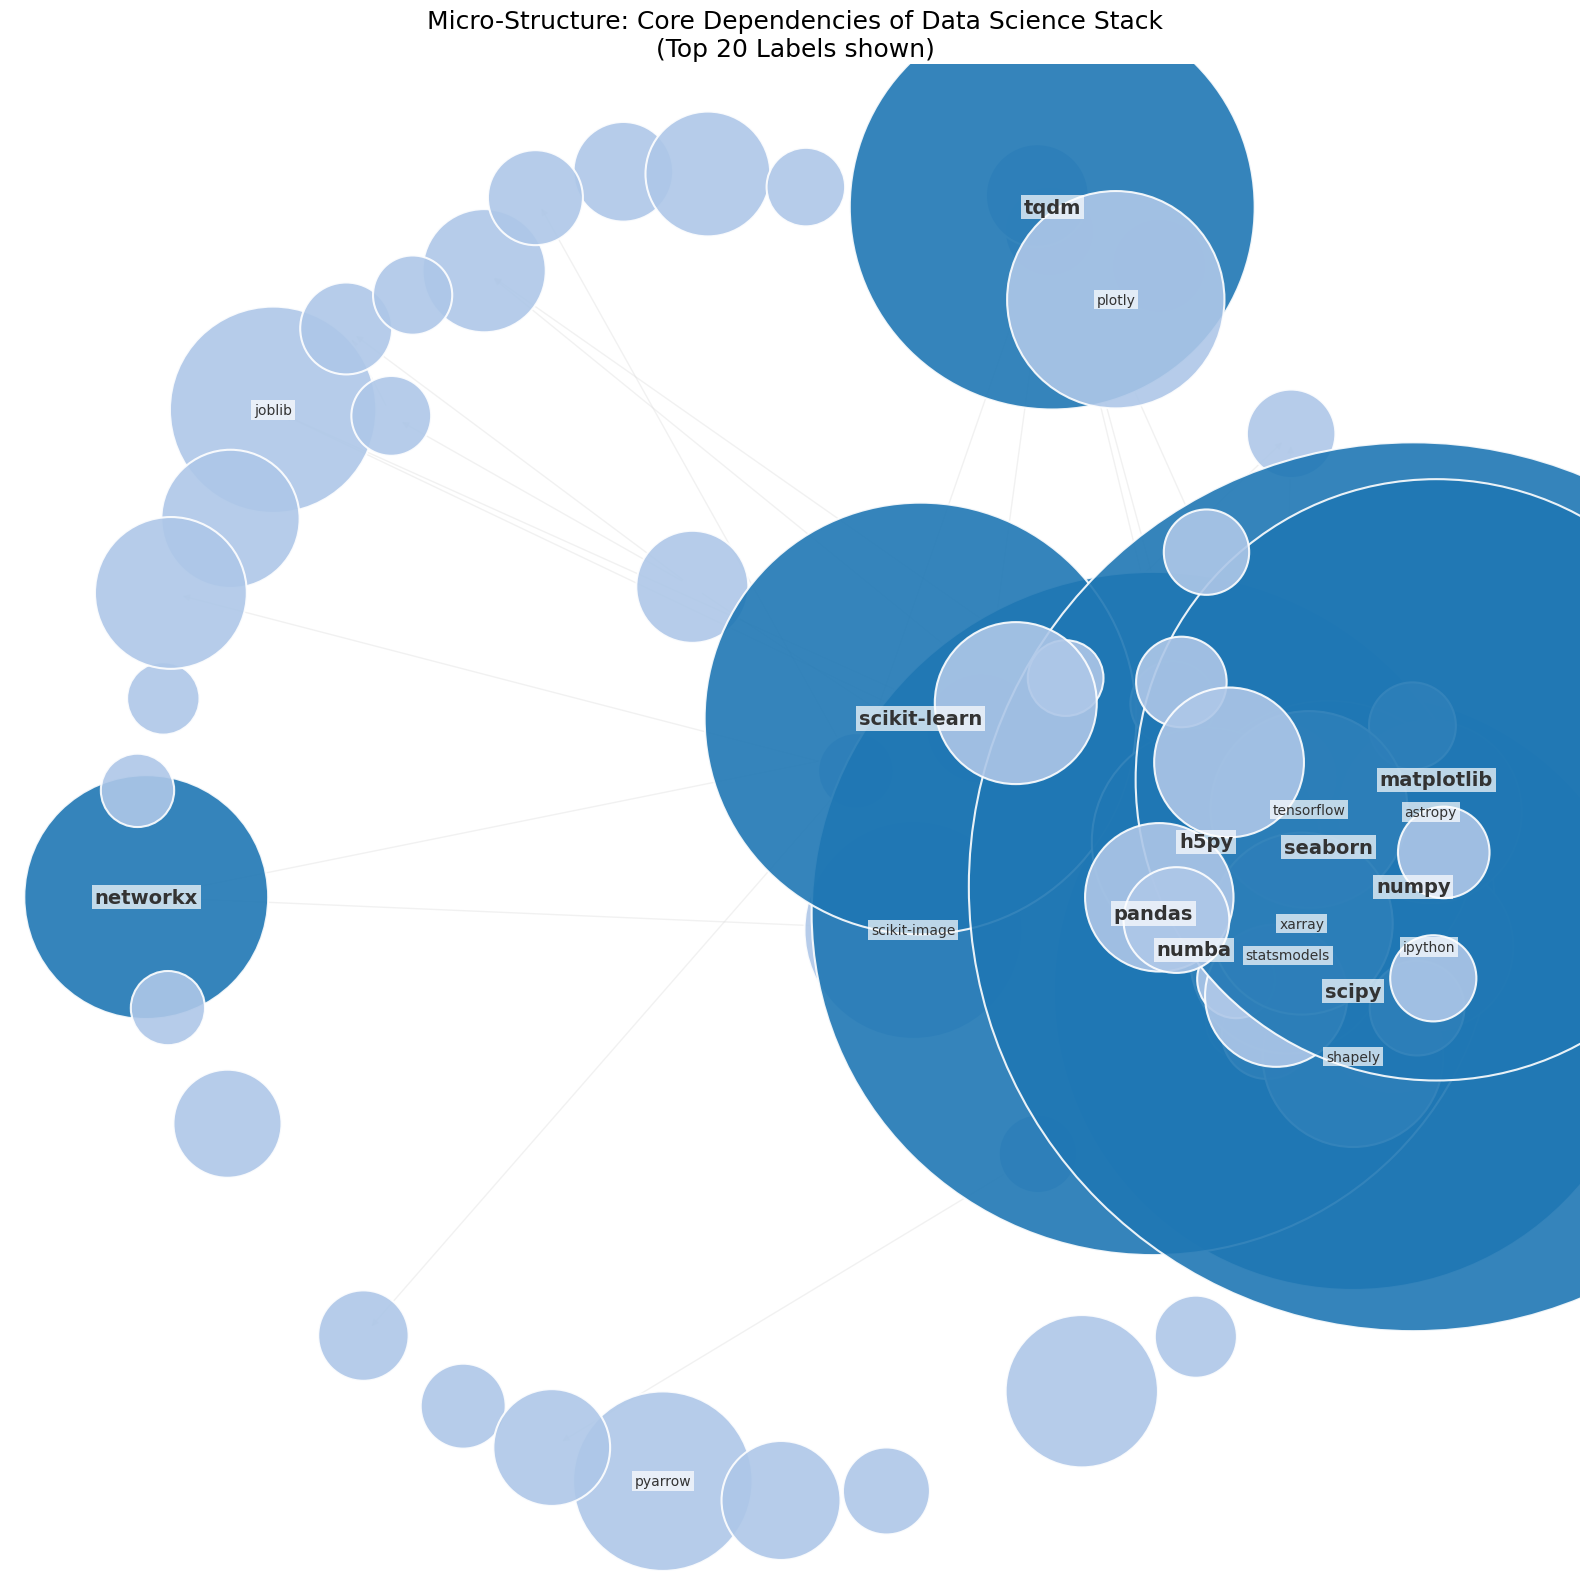

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# ================= CONFIGURATION =================
REAL_DATA_PATH = r"E:\Network Science Project\RealData"
EDGES_PATH = r"E:\Network Science Project\pypi_dag\edges.csv"
PARTITION_FILE = "pypi_full_partition_realdata.csv"

TARGET_COMMUNITY_ID = 6  # Data Science Stack
TOP_N_NODES = 80         # 画出80个点维持结构感
LABEL_TOP_N = 20         # !!! 只给前20个打标签，防止重叠看不清 !!!
# =================================================

def plot_stack_core_beautiful():
    print(f"--- Visualizing Core of Stack {TARGET_COMMUNITY_ID} ---")
    
    # 1. 读取数据 (带dtype修复)
    part_df = pd.read_csv(os.path.join(REAL_DATA_PATH, PARTITION_FILE), dtype={'CommunityID': 'int64'})
    stack_nodes = set(part_df[part_df['CommunityID'] == TARGET_COMMUNITY_ID]['PackageName'])
    
    if not stack_nodes:
        print("Error: No nodes found.")
        return

    edges_df = pd.read_csv(EDGES_PATH)
    mask = edges_df['source'].isin(stack_nodes) & edges_df['target'].isin(stack_nodes)
    stack_edges = edges_df[mask]
    G_stack = nx.from_pandas_edgelist(stack_edges, create_using=nx.DiGraph())
    
    # 2. 提取子图
    degrees = dict(G_stack.in_degree())
    top_core_nodes = sorted(degrees, key=degrees.get, reverse=True)[:TOP_N_NODES]
    G_core = G_stack.subgraph(top_core_nodes)
    
    # 3. 布局优化 (关键修改)
    plt.figure(figsize=(16, 16))
    
    # 使用 k=1.5 或更大，强行拉开距离
    # iterations=200 确保跑得更稳
    pos = nx.spring_layout(G_core, k=0.8, iterations=200, seed=42) 
    
    # 4. 样式设计
    # 大小：基于入度，但是稍微温和一点的缩放
    node_sizes = [degrees[n] * 8 + 100 for n in G_core.nodes()]
    
    # 颜色：根据重要性渐变
    # Top 10 用深蓝色，其他的用浅蓝色
    top_10 = set(sorted(degrees, key=degrees.get, reverse=True)[:10])
    node_colors = ['#1f77b4' if n in top_10 else '#aec7e8' for n in G_core.nodes()]
    
    # 5. 绘制
    # 边：非常的淡，作为背景
    nx.draw_networkx_edges(G_core, pos, edge_color='#dddddd', alpha=0.4, arrowsize=10, width=1)
    
    # 节点
    nx.draw_networkx_nodes(G_core, pos, node_size=node_sizes, node_color=node_colors, 
                           alpha=0.9, edgecolors='white', linewidths=1.5)
    
    # 6. 标签策略 (只标重点)
    labels = {}
    top_label_nodes = sorted(degrees, key=degrees.get, reverse=True)[:LABEL_TOP_N]
    
    for n in top_label_nodes:
        labels[n] = n # 只保留名字
            
    # 使用白色背景框，让字浮在连接线上面
    for node, label in labels.items():
        x, y = pos[node]
        # 字体大小根据节点重要性动态调整
        font_size = 14 if node in top_10 else 10
        font_weight = 'bold' if node in top_10 else 'normal'
        
        plt.text(x, y, label, fontsize=font_size, fontweight=font_weight, 
                 color='#333333',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
                 horizontalalignment='center', verticalalignment='center')

    plt.title(f"Micro-Structure: Core Dependencies of Data Science Stack\n(Top {LABEL_TOP_N} Labels shown)", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_stack_core_beautiful()

--- Visualizing Core of Stack 6 (Refined) ---
Calculating layout...


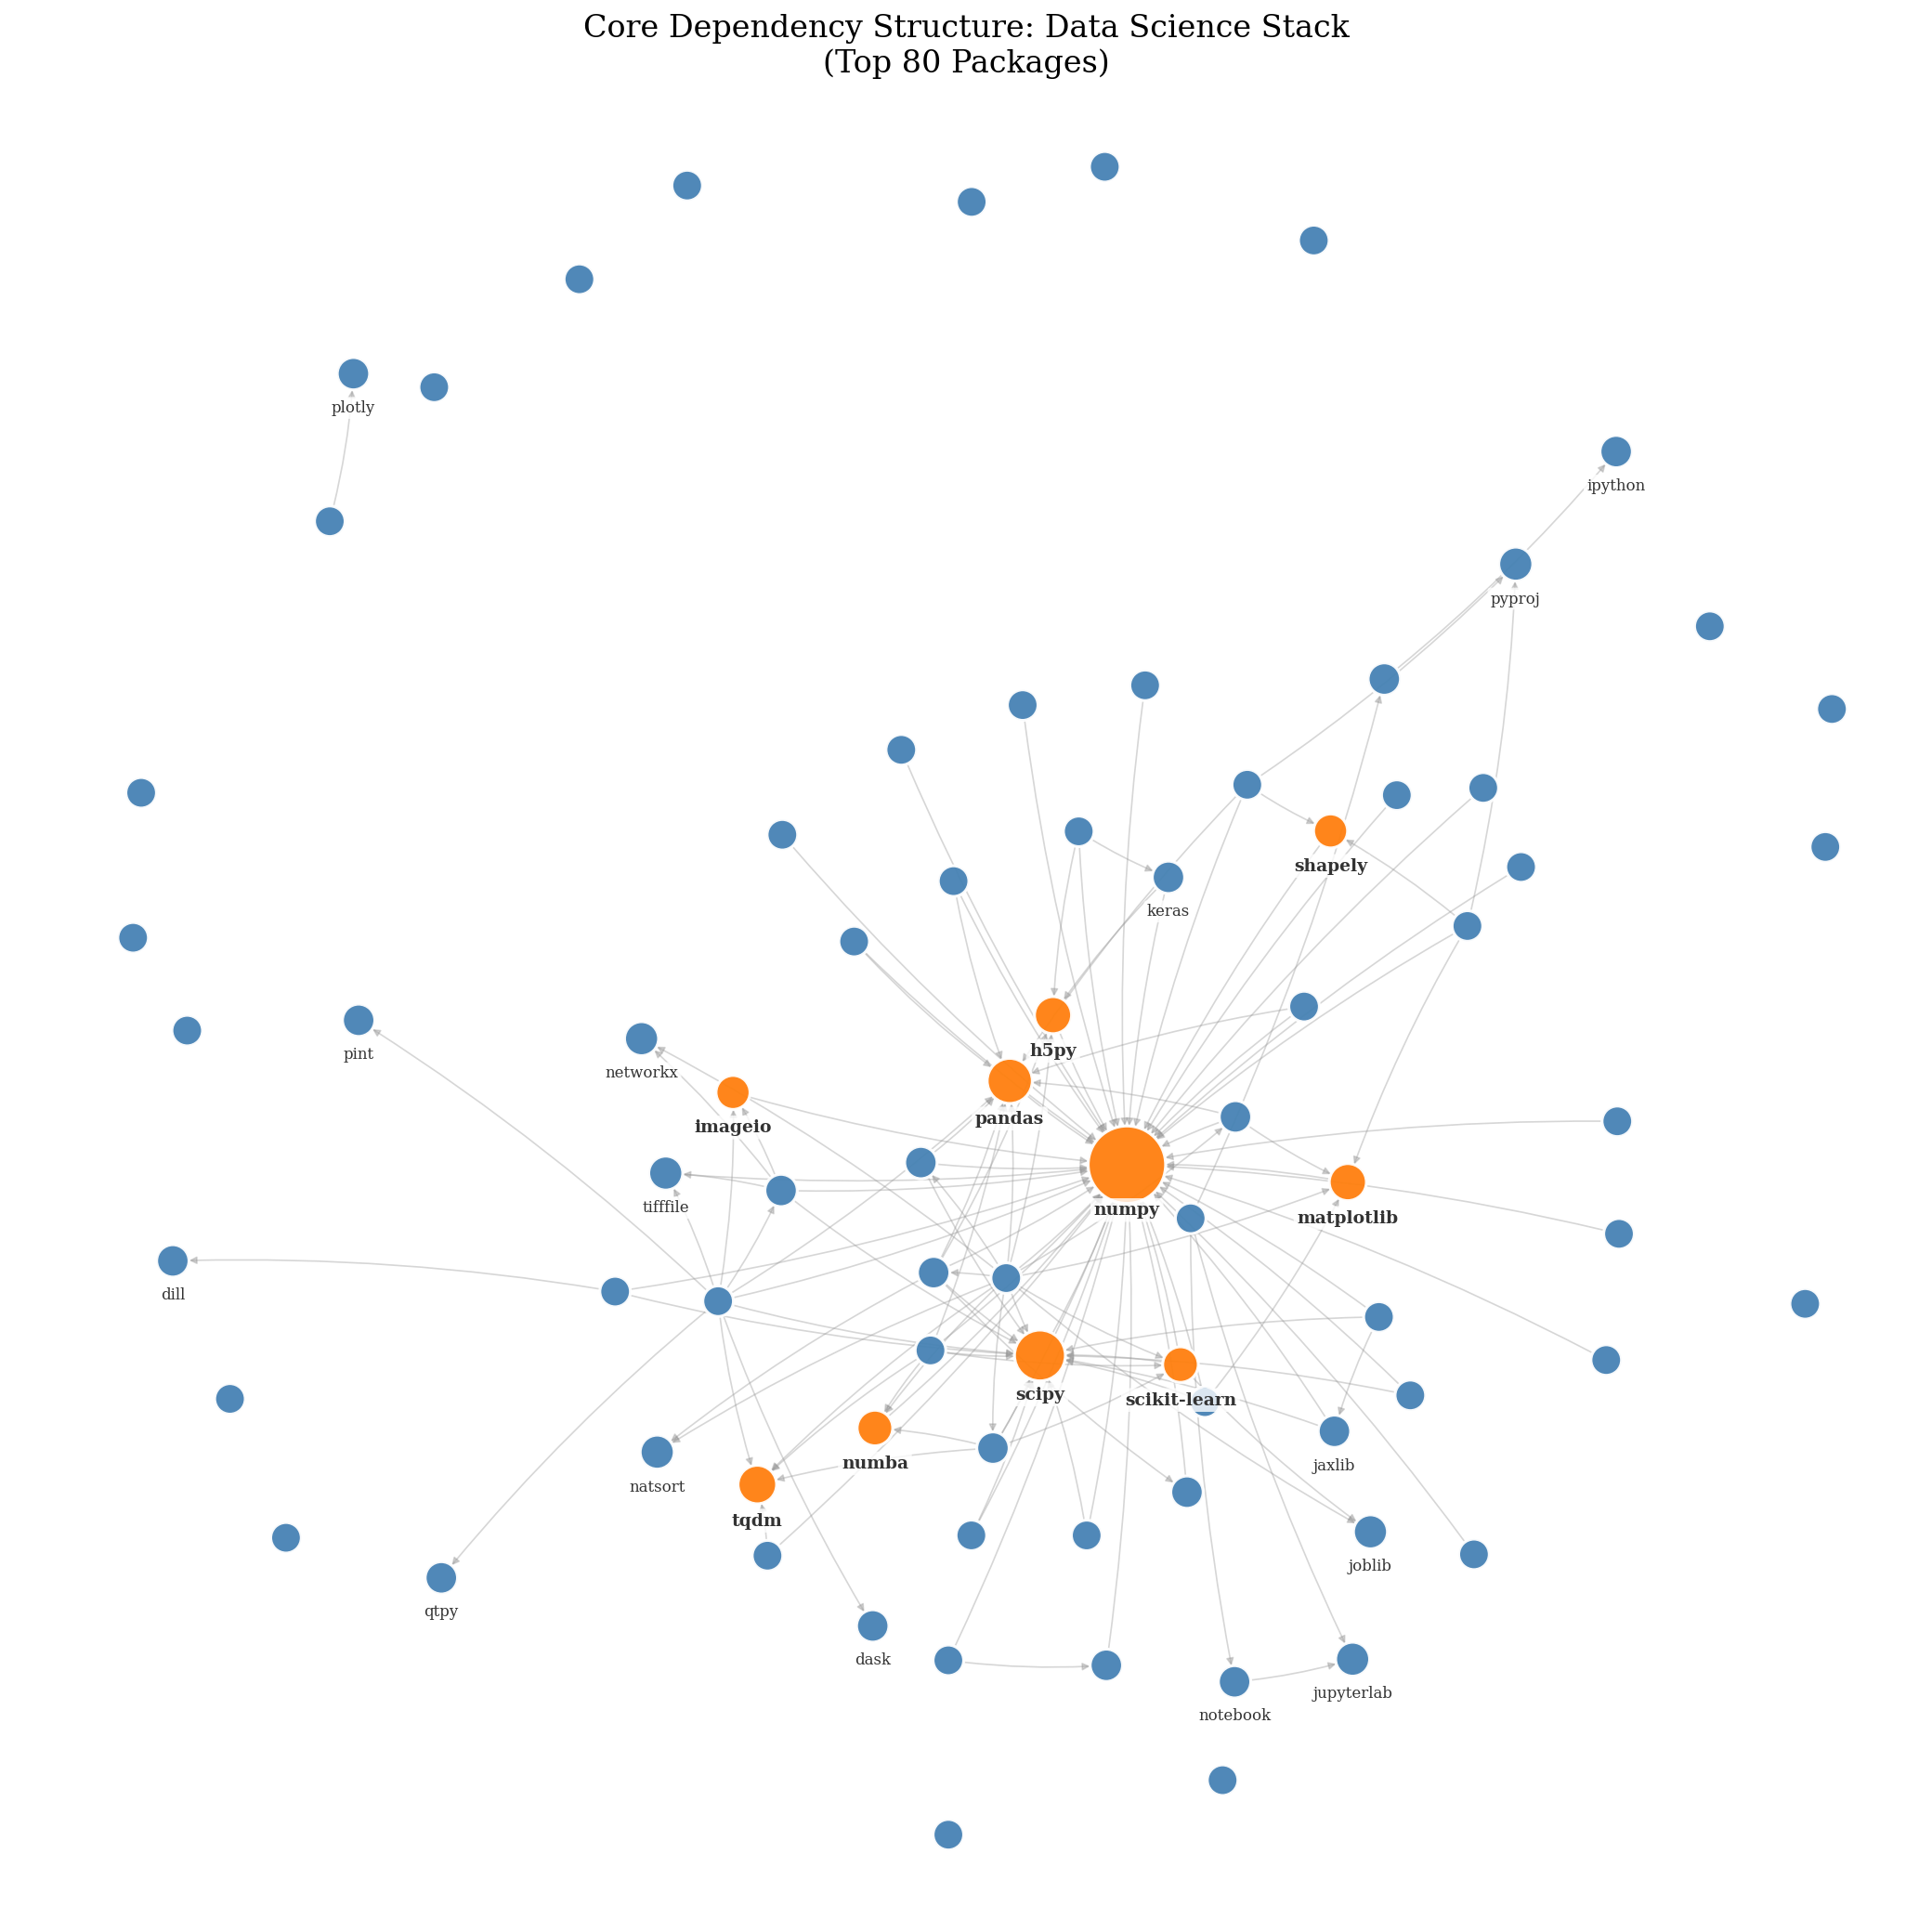

In [35]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

# ================= CONFIGURATION =================
REAL_DATA_PATH = r"E:\Network Science Project\RealData"
EDGES_PATH = r"E:\Network Science Project\pypi_dag\edges.csv"
PARTITION_FILE = "pypi_full_partition_realdata.csv"

TARGET_COMMUNITY_ID = 6  # Data Science Stack
TOP_N_NODES = 80         # 节点数
LABEL_TOP_N = 25         # 稍微多标几个，因为现在的布局能容纳更多
# =================================================

def rescale_node_sizes(degrees, min_size=300, max_size=1800):
    """
    将节点度数映射到一个合理的像素大小范围，防止节点过大或过小。
    """
    vals = np.array(list(degrees.values()))
    min_deg, max_deg = vals.min(), vals.max()
    
    if min_deg == max_deg:
        return {n: (min_size + max_size) / 2 for n in degrees}
    
    # 线性映射
    sizes = {}
    for node, deg in degrees.items():
        norm = (deg - min_deg) / (max_deg - min_deg)
        sizes[node] = min_size + norm * (max_size - min_size)
    return sizes

def plot_stack_core_refined():
    print(f"--- Visualizing Core of Stack {TARGET_COMMUNITY_ID} (Refined) ---")
    
    # 1. 读取数据
    try:
        part_df = pd.read_csv(os.path.join(REAL_DATA_PATH, PARTITION_FILE), dtype={'CommunityID': 'int64'})
        stack_nodes = set(part_df[part_df['CommunityID'] == TARGET_COMMUNITY_ID]['PackageName'])
        
        edges_df = pd.read_csv(EDGES_PATH)
        mask = edges_df['source'].isin(stack_nodes) & edges_df['target'].isin(stack_nodes)
        stack_edges = edges_df[mask]
        
        G_stack = nx.from_pandas_edgelist(stack_edges, create_using=nx.DiGraph())
    except Exception as e:
        print(f"Data loading error: {e}")
        return

    # 2. 提取 Top-N 子图
    if len(G_stack) == 0:
        print("No nodes found.")
        return

    degrees = dict(G_stack.in_degree())
    # 选出度最高的 N 个点
    top_core_nodes = sorted(degrees, key=degrees.get, reverse=True)[:TOP_N_NODES]
    G_core = G_stack.subgraph(top_core_nodes).copy()
    
    # 重新计算子图内的度数（为了让大小更准确反映局部重要性）
    sub_degrees = dict(G_core.in_degree())

    # 3. 布局优化 (关键步骤)
    print("Calculating layout...")
    # 使用无向图计算布局，通常能获得更好的对称性和结构感
    # k=0.5: 斥力系数。值越大节点越分散。对于80个点，0.4-0.6 是比较好的范围。
    pos = nx.spring_layout(G_core.to_undirected(), k=0.9, iterations=100, seed=42)

    # 4. 样式计算
    # 4.1 节点大小：严格控制范围
    node_size_map = rescale_node_sizes(sub_degrees, min_size=250, max_size=1600)
    node_sizes = [node_size_map[n] for n in G_core.nodes()]
    
    # 4.2 节点颜色：Top Hubs 突出显示
    top_10 = set(sorted(sub_degrees, key=sub_degrees.get, reverse=True)[:10])
    # Hubs: 橙色 (#ff7f0e), 普通点: 钢蓝色 (#4682b4)
    node_colors = ['#ff7f0e' if n in top_10 else '#4682b4' for n in G_core.nodes()]

    # 5. 开始绘制
    plt.figure(figsize=(14, 14), dpi=150) # 提高分辨率
    ax = plt.gca()

    # 5.1 绘制边 (Edges)
    # 使用深灰色，透明度适中，确保能看清连接关系
    nx.draw_networkx_edges(G_core, pos, 
                           edge_color='#999999', 
                           alpha=0.4, 
                           arrowsize=8, 
                           width=0.8, 
                           node_size=node_sizes, # 确保箭头不会被节点遮住
                           connectionstyle="arc3,rad=0.05") # 稍微一点点弧度增加美感

    # 5.2 绘制节点 (Nodes)
    # 使用白色描边 (linewidths) 将节点与背景连线隔开
    nx.draw_networkx_nodes(G_core, pos, 
                           node_size=node_sizes, 
                           node_color=node_colors, 
                           alpha=0.95, 
                           edgecolors='white', 
                           linewidths=1.5)

    # 6. 标签策略 (Labels)
    labels = {}
    top_label_nodes = sorted(sub_degrees, key=sub_degrees.get, reverse=True)[:LABEL_TOP_N]
    
    for node in top_label_nodes:
        x, y = pos[node]
        label = node
        
        # 字体样式
        is_hub = node in top_10
        # font_size = 13 if is_hub else 9
        font_size = 9 if is_hub else 8
        font_weight = 'bold' if is_hub else 'normal'
    
        
        # 计算偏移量：根据节点大小，将文字向下移动，避免压在圆圈上
        # 估算半径 (sqrt(size) 粗略成正比)
        radius_offset = 0.02 + 0.0005 * np.sqrt(node_size_map[node])
        
        plt.text(x, y - radius_offset, label, 
                 fontsize=font_size, 
                 fontweight=font_weight, 
                 color='#333333',
                 horizontalalignment='center', 
                 verticalalignment='top', # 文字顶部对齐偏移点
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8), # 白底背景框
                 zorder=10) # 保证文字在最上层

    plt.title(f"Core Dependency Structure: Data Science Stack\n(Top {TOP_N_NODES} Packages)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_stack_core_refined()